# Chapter: Dimension Reduction and Latent Variable Methods (Part 2)¶

# Topic: Fault Classification via FDA

In [37]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                           Fault classification via FDA for TEP data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [38]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# fetch TEP data for faults 5,10,19 
TEdata_Fault5_train = np.loadtxt('d05.dat')
TEdata_Fault10_train = np.loadtxt('d10.dat')
TEdata_Fault19_train = np.loadtxt('d19.dat')
TEdata_Faulty_train = np.vstack((TEdata_Fault5_train, TEdata_Fault10_train, TEdata_Fault19_train))

# select variables as done in Lee et al.
xmeas = TEdata_Faulty_train[:,0:22]
xmv = TEdata_Faulty_train[:,41:52]
data_Faulty_train = np.hstack((xmeas, xmv))

# generate sample labels
n_rows_train = TEdata_Fault5_train.shape[0]
y_train = np.concatenate((5*np.ones(n_rows_train,), 10*np.ones(n_rows_train,), 19*np.ones(n_rows_train,)))

In [40]:
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Faultydata_train_scaled = scaler.fit_transform(data_Faulty_train)

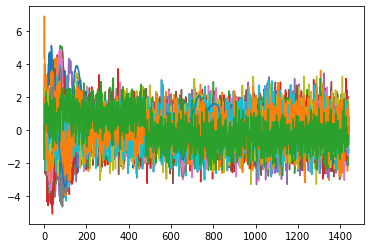

In [41]:
#  visualize all scaled variables
plt.figure()
plt.plot(Faultydata_train_scaled)
plt.show()

In [42]:
# fit LDA model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
scores_train_lda = lda.fit_transform(Faultydata_train_scaled, y_train)

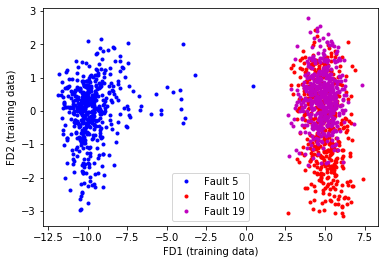

In [43]:
# visualize LDA scores
plt.figure()
plt.plot(scores_train_lda[0:n_rows_train,0], scores_train_lda[0:n_rows_train,1], 'b.', label='Fault 5')
plt.plot(scores_train_lda[n_rows_train:2*n_rows_train,0], scores_train_lda[n_rows_train:2*n_rows_train,1], 'r.', label='Fault 10')
plt.plot(scores_train_lda[2*n_rows_train:3*n_rows_train,0], scores_train_lda[2*n_rows_train:3*n_rows_train,1], 'm.', label='Fault 19')
plt.legend()
plt.xlabel('FD1 (training data)')
plt.ylabel('FD2 (training data)')
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Control limit determination for fault5 class
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [44]:
import scipy.stats
Nj = n_rows_train
k = 2

alpha = 0.01# 99% control limit
T2_CL = k*(Nj**2-1)*scipy.stats.f.ppf(1-alpha,k,Nj-k)/(Nj*(Nj-k))

In [45]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Fault classification with fault 5 test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [46]:
# mean and covariance for Fault 5 class
scores_train_lda_Fault5 = scores_train_lda[0:n_rows_train,:]
cov_scores_train_Fault5 = np.cov(scores_train_lda_Fault5.T)
mean_scores_train_Fault5 = np.mean(scores_train_lda_Fault5, axis = 0)

In [47]:
# fetch TE test dta for fault 5
TEdata_Fault5_test = np.loadtxt('d05_te.dat')
TEdata_Fault5_test = TEdata_Fault5_test[160:,:]
n_rows_test = TEdata_Fault5_test.shape[0]

# select variables as done in Lee et al.
xmeas = TEdata_Fault5_test[:,0:22]
xmv = TEdata_Fault5_test[:,41:52]
data_Faulty_test = np.hstack((xmeas, xmv))

In [48]:
# scale data and transform
Faultydata_test_scaled = scaler.transform(data_Faulty_test)
scores_test_lda = lda.transform(Faultydata_test_scaled)

In [49]:
# compute T2 statistic for test data for Fault 5 class
T2_test = np.zeros((n_rows_test,))
for sample in range(n_rows_test):
    score_sample = scores_test_lda[sample,:]
    score_sample_centered = score_sample - mean_scores_train_Fault5
    T2_test[sample] = np.dot(np.dot(score_sample_centered[np.newaxis,:],np.linalg.inv(cov_scores_train_Fault5)),score_sample_centered[np.newaxis,:].T)

Percentage  of samples correctly diagnosed as Fault 5:  98.375


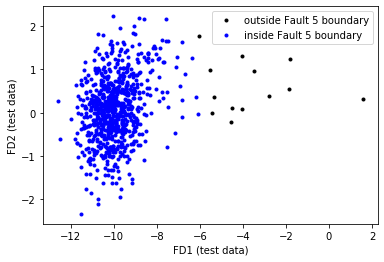

In [50]:
# plot test prediction
outsideCL_flag = T2_test > T2_CL
insideCL_flag = T2_test <= T2_CL
plt.figure()
plt.plot(scores_test_lda[outsideCL_flag,0], scores_test_lda[outsideCL_flag,1], 'k.', label='outside Fault 5 boundary')
plt.plot(scores_test_lda[insideCL_flag,0], scores_test_lda[insideCL_flag,1], 'b.', label='inside Fault 5 boundary')
plt.xlabel('FD1 (test data)')
plt.ylabel('FD2 (test data)')
plt.legend()

print('Percentage  of samples correctly diagnosed as Fault 5: ', 100*np.sum(T2_test < T2_CL)/n_rows_test)